# A Tutorial on Noise-Free Gaussian Process Regression
## *Theory and Practice*
***

#### By Jerry Jeyachandra [(github)](https://www.github.com/jerdra)
##### Sourced from Rasmussen & Williams (2006)
***

This is a tutorial on **Gaussian Process $(\mathcal{GP})$ Regression** in the **Noise-free** setting (observations provide perfect information) 

This is the context in which **Bayesian Optimization** is performed, that is, we have some underlying function that we don't have access to entirely and can only learn about by sampling points. With **Bayesian Optimization** we want to optimally select points as to learn as much as we can about the underlying function without sampling too often; each evaluation of the true objective function is expensive. 

**$\mathcal{GP}$ Regression** allows us to model the model parameter space probabilistically, giving us a framework to explore our model space with some assumptions of underlying structure.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.spatial.distance import pdist, squareform #pairwise distance; convert upper triangular to square

In [2]:
#This is the true function we want to model with our gaussian process regression 
#Yes, it's ugly, and you'd never guess from just looking at it, but that's the point
def true_func(x):
    return 0.1*((8*np.exp(-0.0125*x))*np.sin(x*0.25) + 0.055*x + 50*np.exp(-10/(1+0.25*x))) - 3

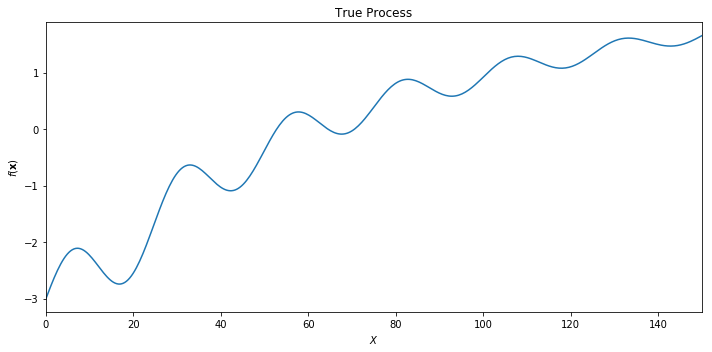

In [3]:
#Generate the true underlying objective function we want to learn about
x = np.linspace(0,150,400)
x = x.reshape((x.shape[0],1)) #column vector of samples
y = true_func(x)

## Visualize
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(x,y)
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$f(\mathbf{x})$')
ax.set_title('True Process')
ax.set_xlim(0,150)

plt.tight_layout()
plt.show()

***
# Gaussian Processes


$\mathcal{GP}$ regression is a Bayesian regression technique that non-parameterically models stochastic processes. Importantly, $\mathcal{GP}$'s model the phenomena of interest probabilistically using *distributions over functions* rather than over *parameters*. While there is some underlying duality here between the **function-space view** of $\mathcal{GP}$ and the traditional **weight-space view** of standard bayesian regression, $\mathcal{GP}$'s are far more flexible and elegant to work with. 

The main idea is to use **covariance kernel functions** in order to imbue loose beliefs (structural assumptions) about the behaviour of the data into our regression model. The beauty of the bayesian side of this model is that we can update our beliefs about the data via **Bayes Theorem** which allows us to integrate evidence (observations) as they come in. 

***

### Definition

Formally, a $\mathcal{GP}$ is a collection random variables in which any finite subset have a **joint Gaussian Distribution**. This implies a property of **consistency**, in that any subset $y$ containing any finite subset of $\mathcal{GP}$ is a multivariate gaussian variable. For example, suppose there are two subsets such that the $\mathcal{GP}$ specifies that:

$$(y_1,y_2) \sim \mathcal{N}(\mathbf{0},\Sigma)$$
Then it must also be true that:
$$y_1 \sim \mathcal{N}(\mathbf{0},\Sigma_{11})$$
Where $\Sigma_{11}$ is a block submatrix from $\Sigma$ corresponding to $y_1$. Note that while $\mathcal{GP}$ is technically infinite-dimensional (it's continuous!), any *finite subset is a multivariate gaussian distribution* - which is an extremely useful property!.


### Specification of $\mathcal{GP}$



The $\mathcal{GP}$ can be fully specified with two components, the **mean function** and the **covariance function**:

$$m(\mathbf{x}) = \mathbb{E}\left[ f(\mathbf{x}) \right]$$
$$k(\mathbf{x}_i,\mathbf{x}_j) = \mathbb{E}\left[ (f(\mathbf{x}_i) - m(\mathbf{x}) ) (f(\mathbf{x}_j) - m(\mathbf{x}) ) \right]$$

We represent the distribution that we believe that our data is drawn from as follows:

$$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}_i,\mathbf{x}_j))$$


Note that the function $f(\mathbf{x})$ is drawn from a probability distribution $\mathcal{GP}$, thus we're dealing with probabilistic functions - $\mathcal{GP}$ is a *distribution over functions*!

Since we're working within a Bayesian framework, we need to specify a prior which reflects our beliefs about the data.

## Specifying our prior

### Mean Function

We begin by making no assumptions about the underlying model's mean behaviour. That is to say, we start with an *uninformed prior*:

$$m(\mathbf{x}) = \mathbf{0}$$

*One could make the argument that the $\mathbf{0}$ function is informed since we assume that our input $X$ is linearly related to our output (which it's not), but that's another discussion that's outside the scope of this tutorial...*

We could be a little bit more informed if we knew something about the underlying function that we're dealing with - but in this case we have no idea since we haven't observed any data at this point. An alternative method would be to first randomly sample the data (or at regular intervals) to build a starting mean function but this will turn out to happen anyway once we start integrating observations into our uninformed prior. 

### Covariance Function

The **covariance function** is where most of the *art/domain knowledge* behind $\mathcal{GP}$ begins. The covariance function is a *statement about what you believe the function you're modelling behaves like*. In the example of noise-free observations it encodes rather simple beliefs; but in the noisy observation setting it becomes an important part of the regression model. Since we know *literally nothing* about the underlying function, we'll make a reasonable assumption that the underlying data is *smooth*. To encode this mathematically we use the **Squared Exponential Distance Function**. 

#### Squared Exponential Distance Function

$$\text{RBF}(\mathbf{x}_i,\mathbf{x}_j) = \exp \left( 
    -\frac{1}{2l^2}\|\mathbf{x}_i - \mathbf{x}_j \|
\right)$$

Where $l$ denotes the length scale constant (this is a hyper-parameter we could optimize over if we chose to).

Importantly, the **Squared Distance Exponential Function** encodes *two beliefs*:

The first can be mathematically expressed as the following:

$$\lim_{\mathbf{x}_i \to \mathbf{x}_j} \|f(\mathbf{x}_i) - f(\mathbf{x}_j) \| \to 0$$
Simply put, we believe that as $\mathbf{x}_i$ gets close to $\mathbf{x}_j$, so too should $f(\mathbf{x}_i)$ and $f(\mathbf{x}_j)$. 

Second, the $\exp$ has a neat property of being *infinitely differentiable*. Any function that contains this property is formally a *smooth function*, thus using $\exp$ in our covariance function lends this property to our model.

The smoothness property is a reasonable assumption in many natural phenomena; any erratically behaving function is difficult to fit since you don't have gradients to take advantage when optimizing your regression parameters

***

This yields our **prior function**, let's denote this hereafter as:

$$\mathbf{f} \sim \mathcal{GP}\left(\mathbf{0},k(\mathbf{x},\mathbf{x}^\prime)\right)$$

$\mathbf{f}$ is therefore our **prior**

***

First let's build our prior model. 


**NOTE**, when we instantiate our prior model we (because we have no choice) create an array of values. This is a *finite collection of random variables*! That means that we are now talking about a *subset* of the $\mathcal{GP}$, and are now dealing with **multivariate gaussian distributions** which *is familiar and easy to deal with*!

So technically, it would be more correct to say:

$$\mathbf{f} \sim \mathcal{N}\left(\mathbf{0},k(\mathbf{x},\mathbf{x}^\prime) \right)$$

We'll use this convention moving forward, cause its true...

In [19]:
#Define the length scale (equivalent to sigma of an RBF kernel), which is dependent on data scales
l = 1/10**2

In [20]:
#Specify the mean function
m_x = np.zeros_like(x)

#Compute the covariance function
dists = pdist(x,metric='sqeuclidean')
K = squareform(dists)
K = np.exp(-l*K)

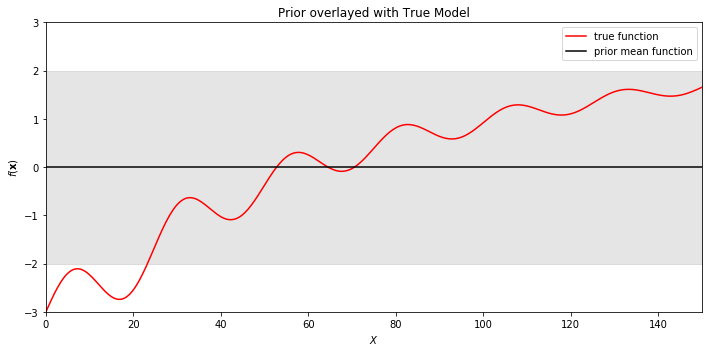

In [22]:
#Make figure canvas
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

#Visualize the true model
ax.plot(x,y,'r', label='true function')

#Visualize the GP prior with 95% confidence zone

#Mean function
ax.plot(x,m_x,'k',label='prior mean function')

#95% confidence interval (approx 2 stds)
plt.fill_between(x[:,0],m_x[:,0] - 2*K.diagonal(), m_x[:,0] + 2*K.diagonal(),color='grey', alpha=0.2)

#Set figure properties
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$f(\mathbf{x})$')
ax.set_title('Prior overlayed with True Model')
ax.set_xlim(left=0,right=150)
ax.set_ylim(bottom=-3,top=3)
plt.tight_layout()
plt.legend()
plt.show()

***
Since $\mathcal{GP}$ is a *distribution of functions* with some intrinsic covariance structure, we can sample the **prior function** as we would for any probability distribution. 

**TODO** Implement function sampling of $\mathcal{GP}$


***

Now that we've specified our **prior function model**, the next step is to sample the data. Updating our $\mathcal{GP}$ model involves the following steps:

1. Sample the data
2. Integrate evidence into our prior using Bayes theorem to compute a **posterior distribution**

We'll manually perform one evaluation by sampling $\mathbf{x}_* \sim \mathcal{X}$, this yields the observation 
$(\mathbf{x_*},f(\mathbf{x_*}))$. For cleaniness let's denote the evalution of the objective function, $f(\mathbf{x}_*)$, as $\mathbf{f_*}$

In [61]:
#Pick an index to sample from
samp_ind = np.random.randint(0,400)

#Make a new array containing learned values
samp_x = x[samp_ind]
samp_fx = true_func(samp_x).reshape((1,1))
print(samp_x,samp_fx)

[145.4887218] [[1.50037796]]


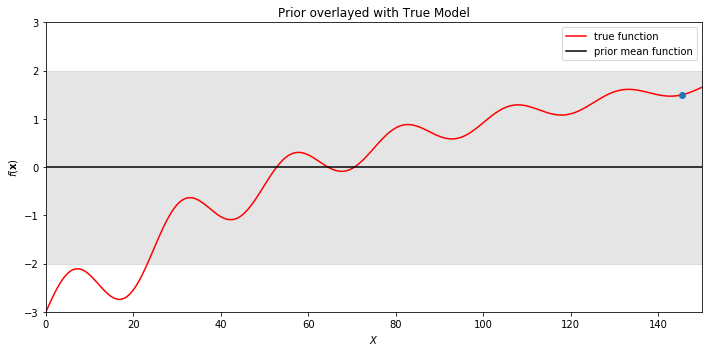

In [62]:
#Make figure canvas
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

#Visualize the true model
ax.plot(x,y,'r', label='true function')

#Visualize the GP prior with 95% confidence zone

#Mean function
ax.plot(x,m_x,'k',label='prior mean function')
ax.plot(samp_x,samp_fx,'o')

#95% confidence interval (Z distribution) using diagonal of prior covariance function
plt.fill_between(x[:,0],m_x[:,0] - 2*K.diagonal(), m_x[:,0] + 2*K.diagonal(),color='grey', alpha=0.2)

#Set figure properties
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$f(\mathbf{x})$')
ax.set_title('Prior overlayed with True Model')
ax.set_xlim(left=0,right=150)
ax.set_ylim(bottom=-3,top=3)
plt.tight_layout()
plt.legend()
plt.show()

### Bayes Theorem
Recall **Bayes Theorem**:

$$P(\text{model} | \text{observations}) = 
\frac{ P(\text{observations} | \text{model}) P(\text{model}) } 
{ P(\text{observations})}$$

In the context of $\mathcal{GP}$, we state **Bayes theorem** as follows:

$$
P(\mathbf{f}| X,X_*,\mathbf{f_*},) = \frac{P(\mathbf{f_*},X_* | X, \mathbf{f})P(\mathbf{f} | X)}
{P( X_*,\mathbf{f}_* | X)}
$$

The posterior distribution is our prior $\mathbf{f}$ conditioned on the current data we have witnessed $(X,X_*,\mathbf{f_*})$

### The posterior distribution

Given a new sample and our current prior, we can calculate the *joint distribution* which is simply the prior distribution (a multivariate gaussian we defined earlier) multiplied by our likelihood function (our observation conditioned on the prior):

$$P(\mathbf{f},\mathbf{f_*},X_*,X) = P( \mathbf{f_*},X_* | X,\mathbf{f})P(\mathbf{f} | X)$$

The *joint distribution* is *also a gaussian distribution* in the form of:

$$
\left[\begin{matrix} 
\mathbf{f} \\
\mathbf{f_*}
\end{matrix}\right] = 
\mathcal{N}\left(\mathbf{0}, 
\left[\begin{matrix}
K(X,\mathbf{x}_*) & K(X,\mathbf{x}_*) \\
K(\mathbf{x}_*,X) & K(\mathbf{x}_*,\mathbf{x}_*)
\end{matrix}\right]\right)
$$

Where $X$ is the prior distribution samples we generated, $\mathbf{x}_*$ is value at which we sampled $\mathcal{X}$. 
Therefore:
- $K(X,X) \in \mathbb{R}^{N, N}$ is the covariance function between all prior distrbution points (we have this)
- $K(X,\mathbf{x}_*) \in \mathbb{R}^{N, M}$ is the covariance function between the prior distribution points and the new sample
- $K(\mathbf{x}_*,X) \in \mathbb{R}^{M,N} = K(X,\mathbf{x}_*)^T$
- $K(\mathbf{x}_*,\mathbf{x}_*) \in \mathbb{R}^{M,M}$ is the covariance function between all new incoming points

The joint covariance matrix is $\Sigma \in \mathbb{R}^{M+N,M+N}$ 
***
**NOTE**: We could've sampled multiple new values to generate $X_*$, the computation will be exactly the same except we'd use the matrix form rather than a single vector $\mathbf{x}_*$. Hereafter we'll just call $\mathbf{x}_*$, $X_*$ for generalizability.
***

Finally, we need to compute the **posterior distribution** which requires us to divide the joint distribution by the **marginal** which is expressed as the following:

$$P(X_*,\mathbf{f_*} | X) = \int P(\mathbf{f_*},X_* | X,\mathbf{f})P(\mathbf{f}|X)d\mathbf{f}$$

Conveniently, it turns out the **posterior distribution**, $\mathbf{f} | X,X_*,\mathbf{f_*}$, is *also a gaussian distribution* (gaussian $\mathbf{f}$ conditioned on gaussian $(X,X_*,\mathbf{f_*})$ is gaussian!) of form:

$$\mathbf{f} | X,X_*,\mathbf{f_*} \sim 
\mathcal{N}(m(\mathbf{x}) + K(X,X_*)K(X_*,X_*)^{-1}\mathbf{f_*},
K(X,X) - K(X,X_*)K(X_*,X_*)^{-1}K(X_*,X))$$


The derivation of the above result is a well known exercise in bayesian statistics, numerous proofs are available all over the internet. It is *long and painful*, but it is entirely doable!
***

Anyhow, let's implement this in practice. Recall we have:
1. a prior distribution $\mathbf{f}$ specified by our **mean function** and **covariance function**
2. A new observation of the form $(X_*,\mathbf{f_*})$

Our goal now is to compute our posterior distribution using the above information. To achieve this, we will implement a small variation on $\text{Algorithm } 2.1$ by Rasmussen & Williams$^1$ (2006) below:

***

$^1 \text{ Algorithm } 2.1$ computes the *predictive distribution* which is $\mathbf{f}_* | \mathbf{f},X,X_*$, we want to compute the *posterior distribution* which is slightly different: $\mathbf{f} | X,X_*,\mathbf{f_*}$
***

First we compute the **posterior mean function** $\bar{\mathbf{f}}$:

$$\bar{\mathbf{f}} = m(\mathbf{x}) + K(X,X_*)K(X_*,X_*)^{-1}\mathbf{f}_*$$

Here's a helpful set of equations to explain the dimensionality of the input data:
$$\mathbb{R}^{N,1} = \mathbb{R}^{N,1} + \mathbb{R}^{N,M}\left[\mathbb{R}^{M,M}\mathbb{R}^{M,1}\right]$$
$$ = \mathbb{R}^{N,1} + \left[\mathbb{R}^{N,M}\mathbb{R}^{M,1}\right]$$
$$ = \mathbb{R}^{N,1} + \mathbb{R}^{N,1}$$

In [63]:
#Compute joint covariance matrix off-diagonals
k_x_xs = np.exp(-l * (x - samp_x)**2)
k_xs_x = k_x_xs.T

#Compute test covariance matrix (in the case of 1 sample it is always 1)
k_xs_xs = np.array([1.0]).reshape((1,1))

#Compute the posterior mean
bar_f = m_x + k_x_xs @ k_xs_xs @ samp_fx

The next step is to compute the **posterior covariance function**. Note that this is given by:

$$\mathbb{V}[\mathbf{f}] = K(X,X) - K(X,X_*)K(X_*,X_*)^{-1}K(X_*,X)$$

Again, we'll show the dimensionality equations:

$$\mathbb{R}^{N,N} = \mathbb{R}^{N,N} - \mathbb{R}^{N,M}\left[\mathbb{R}^{M,M}\mathbb{R}^{M,N}\right]$$
$$ = \mathbb{R}^{N,N} - \left[\mathbb{R}^{N,M}\mathbb{R}^{M,N}\right]$$
$$ = \mathbb{R}^{N,N} - \mathbb{R}^{N,N} $$

In [84]:
#Compute the posterior variance
var_f = K - k_x_xs @ np.linalg.pinv(k_xs_xs) @ k_xs_x

Let's visualize how our estimate of the true underlying distribution changes when we observe a sample!

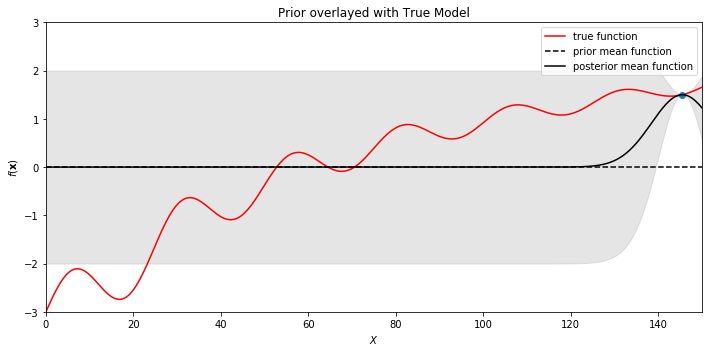

In [75]:
#Now we'll visualize the posterior predictive distribution
#Make figure canvas
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

#Visualize the true model
ax.plot(x,y,'r', label='true function')

#Visualize the GP prior with 95% confidence zone

#Prior mean function
ax.plot(x,m_x,'k--',label='prior mean function')
ax.plot(samp_x,samp_fx,'o')

#Posterior Mean function
ax.plot(x,bar_f,'k', label='posterior mean function')

#95% confidence interval (Z distribution) using diagonal of prior covariance function
plt.fill_between(x[:,0],bar_f[:,0] - 2*var_f.diagonal(), bar_f[:,0] + 2*var_f.diagonal(),color='grey', alpha=0.2)

#Set figure properties
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$f(\mathbf{x})$')
ax.set_title('Prior overlayed with True Model')
ax.set_xlim(left=0,right=150)
ax.set_ylim(bottom=-3,top=3)
plt.tight_layout()
plt.legend()
plt.show()

The beautiful thing about bayesian statistics is that our *posterior distribution becomes the prior* for our next iteration. In fact we can keep iterating and over time we'll be able to pretty accurately approximate the underlying distribution confidently. Below, we wrap everything we did earlier in convenient functions in order to visualize the entire sampling process

In [77]:
def true_func(x):
    return 0.1*((8*np.exp(-0.0125*x))*np.sin(x*0.25) + 0.055*x + 50*np.exp(-10/(1+0.25*x))) - 3

In [80]:
#Define the squared exponential distance function
def sq_exp_dist(x,l=1.0):
    '''
    Compute squared exponential distance pairwise
    l is the characteristic length scale hyperparameter
    '''
    dists = pdist(x,metric='sqeuclidean')
    K = squareform(dists)
    K = np.exp(-l*K)
    return K

In [81]:
def pick_sample(x):
    '''
    Draw a sample from the input domain x
    '''
    
    samp_ind = np.random.randint(0,400)
    x_s = x[samp_ind]
    f_s = true_func(x_s).reshape((1,1))
    return x_s, f_s

In [86]:
def compute_posterior(x,x_s,f,f_s,K,l):
    '''
    Compute posterior distribution 
    x   -- input domain [N,1]
    x_s -- sample [M,M]
    f   -- prior mean function [N,1]
    f_s -- evaluated true function at sample x_s
    K   -- prior covariance matrix
    l   -- characteristic length scale hyperparameter
    '''
    
    #Compute joint covariance matrix components
    K_x_xs = np.exp(-l * (x - samp_x)**2)
    K_xs_x = K_x_xs.T
    K_xs_xs = np.array([1.0]).reshape((1,1))
    
    #Compute posterior distribution
    bar_f = f + K_x_xs @ K_xs_xs @ f_s
    var_f = K - K_x_xs @ np.linalg.pinv(K_xs_xs) @ K_xs_x
    
    return bar_f,var_f